In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt

from MARBLE import utils, geometry, net, plotting

In [2]:
def initial_conditions(n, reps, seed=0):
    X0_range = [geometry.sample_2d(n, [[-3,-3],[3,3]], 'random', seed=seed+i) for i in range(reps)]
        
    return X0_range

def simulate_system(mu, X0, t, eps=1e-10):
    p, v = simulate_phase_portrait('vanderpol', t, X0, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = np.where((abs(p_) < 3).all(1))[0]
        p_ = p_[ind,:]; v_ = v_[ind,:]
        ind = np.where((abs(v_) > eps).any(1))[0]
        p_ = p_[ind,:]; v_ = v_[ind,:]
        pos.append(p_)
        vel.append(v_)
        
    return pos, vel

def plot_phase_portrait(pos, vel, ax=None, node_feature=None):
    if not isinstance(pos, list):
        pos = [pos]
    if not isinstance(vel, list):
        vel = [vel]

    for p, v in zip(pos, vel):
        ax = plotting.trajectories(p, v, ax=ax, style='>', node_feature=node_feature, lw=2, arrowhead=.1, axis=False, alpha=1.)
    ax.axis('square')
    
def reject_outliers(data, m=1):
    data = data.mean(1)
    return np.where(abs(data - np.median(data)) < m * np.std(data))[0]

def plot_embedding(emb, ax, slices, i, n_clusters=2):
    s = range(slices[i], slices[i+1])
    clusters = geometry.cluster(emb, cluster_typ='kmeans', n_clusters=n_clusters, seed=0)
    plotting.embedding(emb[s], clusters['labels'][s], ax=ax[0])
    plot_phase_portrait(pos_subsample[i], vel_subsample[i], ax[1], node_feature=clusters['labels'][s])

# For initial conditions, sample a rectangle uniformly

In [3]:
t0, t1, dt = 0, 2, 0.5
t = np.arange(t0, t1, dt)
n = 150

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [4]:
n_steps=10
beta1 = np.hstack((np.linspace(-0.5,0.5,n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), seed=0)
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i], t)
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Display state spaces under four different parameter conditions

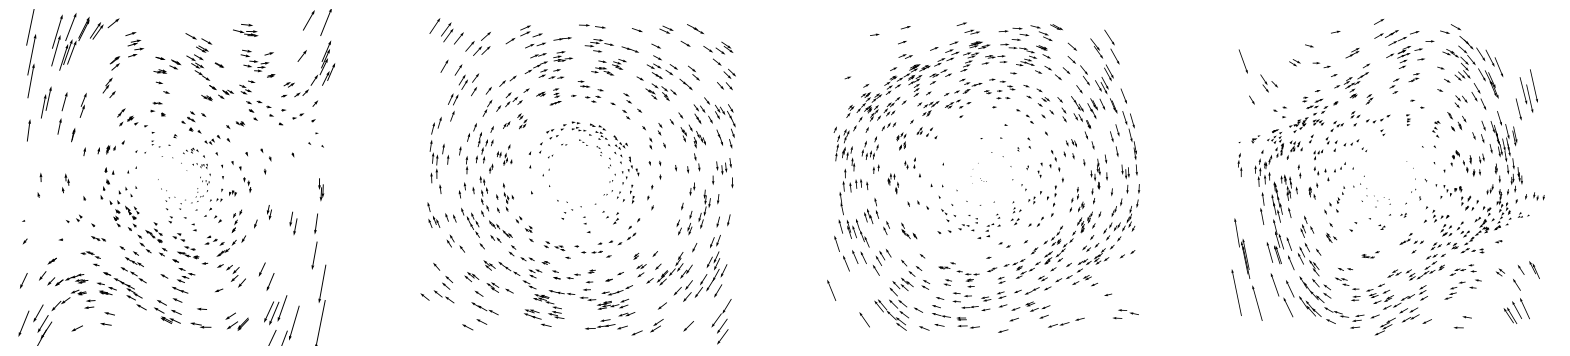

In [5]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
plot_phase_portrait(pos[0], vel[0], ax[0])
plot_phase_portrait(pos[n_steps//2-1], vel[n_steps//2-1], ax[1])
plot_phase_portrait(pos[n_steps//2+1], vel[n_steps//2+1], ax[2])
plot_phase_portrait(pos[-1], vel[-1], ax[3])

# Train network

In [6]:
k=10

data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=k)

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

par = {'batch_size': 512, #batch size
       'epochs': 60, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'diffusion': False,
       'inner_product_features': True,
       'pretrained':False,
       'second_training': True
      }

model = net(data, **par)
model.run_training(data)

---- Settings: 

batch_size : 512
epochs : 60
order : 2
n_lin_layers : 2
hidden_channels : 16
out_channels : 3
diffusion : False
inner_product_features : True
pretrained : False
second_training : True
lr : 0.01
vector : False
frac_geodesic_nb : 2.0
frac_sampled_nb : -1
var_explained : 0.9
diffusion_method : spectral
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_geodesic_nb : 20
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  208
---- Treating features as scalar channels.

---- Training network ... 

Epoch: 1, Training loss: 12.3482, Validation loss: 21.5427
Epoch: 2, Training loss: 11.7240, Validation loss: 19.7512
Epoch: 3, Training loss: 10.8406, Validation loss: 17.7592
Epoch: 4, Training loss: 10.6166, Validation loss: 19.4206
Epoch: 5, Training loss: 10.4645, Validation loss: 18.1211
Epoch: 6, Training loss: 10.2495, Validation loss: 17.4767
Epoch: 7, Training los

# Create another dataset from a different sampling

In [8]:
t0, t1, dt = 0, 1, 0.2
t = np.arange(t0, t1, dt)
n = 100

n_steps=10
beta1 = np.hstack((np.linspace(-0.5, 0.5, n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), seed=10) #change seed
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i], t)
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
data_transfer = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=k)

# Evalute network on both data

In [9]:
data = model.evaluate(data) #original data
data_transfer = model.evaluate(data_transfer) #resampled data

Performed MDS embedding on embedded results.
Performed MDS embedding on embedded results.


<AxesSubplot:>

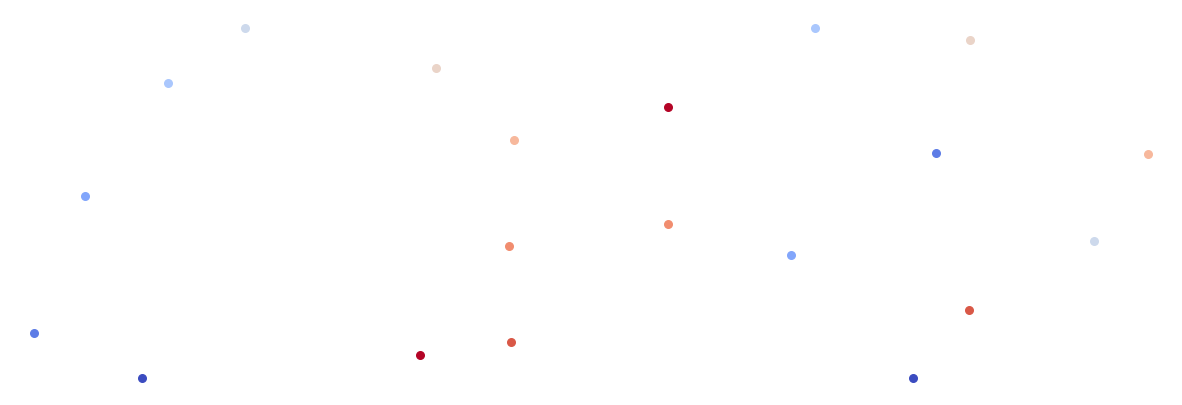

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

dist, gamma = geometry.compute_distribution_distances(data)
emb_MDS, _ = geometry.embed(dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1, ax=ax[0], s=30, alpha=1)

dist_transfer, gamma_transfer = geometry.compute_distribution_distances(data_transfer)
emb_MDS_transfer, _ = geometry.embed(dist_transfer, embed_typ = 'MDS')
plotting.embedding(emb_MDS_transfer, beta1, ax=ax[1], s=30, alpha=1)

# Compare distance matrices

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(dist)
ax[1].imshow(dist_transfer)

# Compare embeddings

In [ ]:
emb, manifold, _, dist, gamma = geometry.cluster_embedding(data, embed_typ='umap', n_clusters=30)
emb_transfer, manifold, _, dist, gamma_transfer = geometry.cluster_embedding(data_transfer, embed_typ='umap', manifold=manifold, n_clusters=30)

titles = ['Original data', 'Transferred data']
plotting.embedding(np.vstack([emb, emb_transfer]), 
                   np.hstack([np.zeros(len(emb)),np.ones(len(emb_transfer))]), 
                   titles=titles)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].imshow(gamma[3,5])
ax[1].imshow(gamma_transfer[3,5])